# Classificação de Imagens Geradas por métodos IA, usando o EfficientNet

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

## Setup e data loading

### Importando e definindo parâmetros do modelo EfficientNet

In [1]:
import numpy as np
import tensorflow as tf  
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0
import pandas as pd

# IMG_SIZE é definido conforme a versão do efficient net
IMG_SIZE = 224
BATCH_SIZE = 32
# NUM_CLASSES precisa ser definido, no caso do problema serão 2, imagens reais e fakes
NUM_CLASSES = 2

2024-12-07 01:32:39.608845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 01:32:39.699274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 01:32:39.723662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 01:32:39.904017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 01:32:41.226307: W tensorflow/compiler/tf2

### Download Dataset Artifact

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/artifact-dataset")

print("Path to dataset files:", path)

/home/vknoguti/.pyenv/versions/3.9.20/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/vknoguti/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1


## Pré-Processamento do Dataset

### Gerar csv de todas imagens

In [6]:
import os
import pandas as pd

# Diretório base onde estão as pastas com os arquivos metadata.csv
base_dir = path
output_csv = "all_images.csv"

# Inicializa uma lista para armazenar os dados
all_data = []

# Percorre todas as subpastas
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "metadata.csv":
            # Caminho completo do arquivo metadata.csv
            metadata_path = os.path.join(root, file)
            
            # Lê o arquivo CSV
            df = pd.read_csv(metadata_path)
            
            # Atualiza o image_path para ser o caminho absoluto
            df['image_path'] = df['image_path'].apply(lambda x: os.path.join(root, x))
            
            # Adiciona a coluna 'label' com base no target
            df['label'] = df['target'].apply(lambda x: 'real' if x == 0 else 'fake')
            
            # Seleciona apenas as colunas desejadas
            df = df[['image_path', 'target', 'label']]
            
            # Adiciona os dados à lista
            all_data.append(df)

# Concatena todos os DataFrames em um único DataFrame
consolidated_df = pd.concat(all_data, ignore_index=True)

# Salva o resultado em um arquivo CSV
consolidated_df.to_csv(output_csv, index=False)

print(f"Arquivo consolidado salvo em {output_csv}")


Arquivo consolidado salvo em all_images.csv


### Seleção das imagens válidas 

In [3]:
import tensorflow as tf
import pandas as pd

def check_images_in_csv(csv_path, output_csv_path):
    # Lista para armazenar os caminhos das imagens válidas
    valid_image_paths = []
    valid_targets = []
    valid_labels = []

    # Lê o CSV com os caminhos das imagens
    df = pd.read_csv(csv_path)

    # Percorre todas as imagens listadas no CSV
    for index, row in df.iterrows():
        image_path = row['image_path']
        target = row['target']
        label = row['label']

        try:
            # Carrega a imagem com TensorFlow
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image)

            # Verifica se a imagem tem dimensão válida
            if image.shape[0] == 0 or image.shape[1] == 0:
                print(f"Imagem vazia encontrada em: {image_path}")
            # Verifica se todos os valores são zero
            elif tf.reduce_max(image) == 0 and tf.reduce_min(image) == 0:
                print(f"Imagem com conteúdo vazio (todos pixels 0) encontrada em: {image_path}")
            else:
                # Adiciona a imagem válida às listas
                valid_image_paths.append(image_path)
                valid_targets.append(target)
                valid_labels.append(label)

        except Exception as e:
            print(f"Erro ao carregar a imagem em {image_path}: {e}")
        
        if index % 50000 == 0:
            print("Imagens Percorridas", index)

    # Cria um novo DataFrame com as imagens válidas
    valid_df = pd.DataFrame({
        'image_path': valid_image_paths,
        'target': valid_targets,
        'label': valid_labels
    })

    # Salva o DataFrame em um novo CSV
    valid_df.to_csv(output_csv_path, index=False)
    print(f"CSV com imagens válidas salvo em: {output_csv_path}")

# Caminho do CSV de entrada e saída
images_csv = "all_images.csv"

# Caminho do novo CSV de saída
output_csv = "validated_images.csv"

print("Verificando imagens do dataset")
check_images_in_csv(images_csv, output_csv)

Verificando imagens do dataset
Imagens Percorridas 0
Imagens Percorridas 50000
Imagens Percorridas 100000
Imagens Percorridas 150000
Imagem com conteúdo vazio (todos pixels 0) encontrada em: /home/vknoguti/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/stable_diffusion/stable/images/img015338.jpg
Imagem com conteúdo vazio (todos pixels 0) encontrada em: /home/vknoguti/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/stable_diffusion/stable/images/img010977.jpg
Imagem com conteúdo vazio (todos pixels 0) encontrada em: /home/vknoguti/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/stable_diffusion/stable/images/img003885.jpg
Imagem com conteúdo vazio (todos pixels 0) encontrada em: /home/vknoguti/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/stable_diffusion/stable/images/img012451.jpg
Imagem com conteúdo vazio (todos pixels 0) encontrada em: /home/vknoguti/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/stable_diffu

## Divisão entre treino e teste das imagens

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

df = pd.read_csv('validated_images.csv')
real = df[df['label'] == 'real']
real = real.sample(frac=1, random_state=22).reset_index(drop=True)

fake = df[df['label'] == 'fake']
fake = fake.sample(frac=1, random_state=75).reset_index(drop=True)

# Pega 20% Inicial
real_20 = real.iloc[:int(0.2 * len(real))]
fake_20 = fake.iloc[:int(0.2 * len(fake))]

# Pega 80% Final
real_80 = real.iloc[int(0.2 * len(real)):]
fake_80 = fake.iloc[int(0.2 * len(fake)):]

# Train e Test gerados
train = pd.concat([real_80, fake_80], ignore_index=True).sample(frac=1, random_state=31)
test = pd.concat([real_20, fake_20], ignore_index=True).sample(frac=1, random_state=31)

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [3]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.utils import shuffle
import numpy as np

# Configurações
# base_dir = "datasets/sep_dataset_artifact"
# train_csv = os.path.join(base_dir, "new_train.csv")
# test_csv = os.path.join(base_dir, "new_test.csv")

train_csv = "train.csv"
test_csv = "test.csv"

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ajuste se necessário para PNG
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Redimensionar aqui
    image = image / 255.0  # Normalizar para [0, 1]
    return image, label

def safe_load_image(image_path, label):
    try:
        return load_image(image_path, label)
    except tf.errors.InvalidArgumentError:
        print(f"Erro ao processar imagem: {image_path}")
        return tf.zeros([IMG_SIZE, IMG_SIZE, 3]), label

# Função para criar datasets
def create_dataset(csv_path, sample_fraction=1):
    df = pd.read_csv(csv_path)
    
    # Amostragem aleatória do DataFrame
    df = shuffle(df.sample(frac=sample_fraction, random_state=42))

    # Verificar se o DataFrame está vazio após amostragem
    if df.empty:
        raise ValueError("DataFrame está vazio após amostragem.")

    file_paths = df["image_path"].values
    labels = df["label"].apply(lambda x: 0 if x == "fake" else 1).values

    # Verificar se os arquivos existem
    valid_df = df['image_path'].apply(lambda x: os.path.exists(x))

    if not valid_df.any():
        raise ValueError("Nenhum arquivo de imagem válido encontrado.")

    print(f"Imagens válidas: {valid_df.sum()}")

    # Cria o dataset TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((file_paths[valid_df], labels[valid_df]))
    dataset = dataset.map(safe_load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset, df[valid_df]

# Carregar os datasets de treino e teste
ds_train, df_train = create_dataset(train_csv, sample_fraction=1)
ds_test, df_test = create_dataset(test_csv, sample_fraction=1)


Imagens válidas: 1997299


I0000 00:00:1733543276.940584  251122 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733543277.181401  251122 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733543277.181720  251122 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733543277.191867  251122 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733543277.192142  251122 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Imagens válidas: 499324


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

### Visualizar amostrar de imagens do Dataset Artifact

2024-12-07 00:48:36.995509: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47935176 exceeds 10% of free system memory.
2024-12-07 00:48:37.379506: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


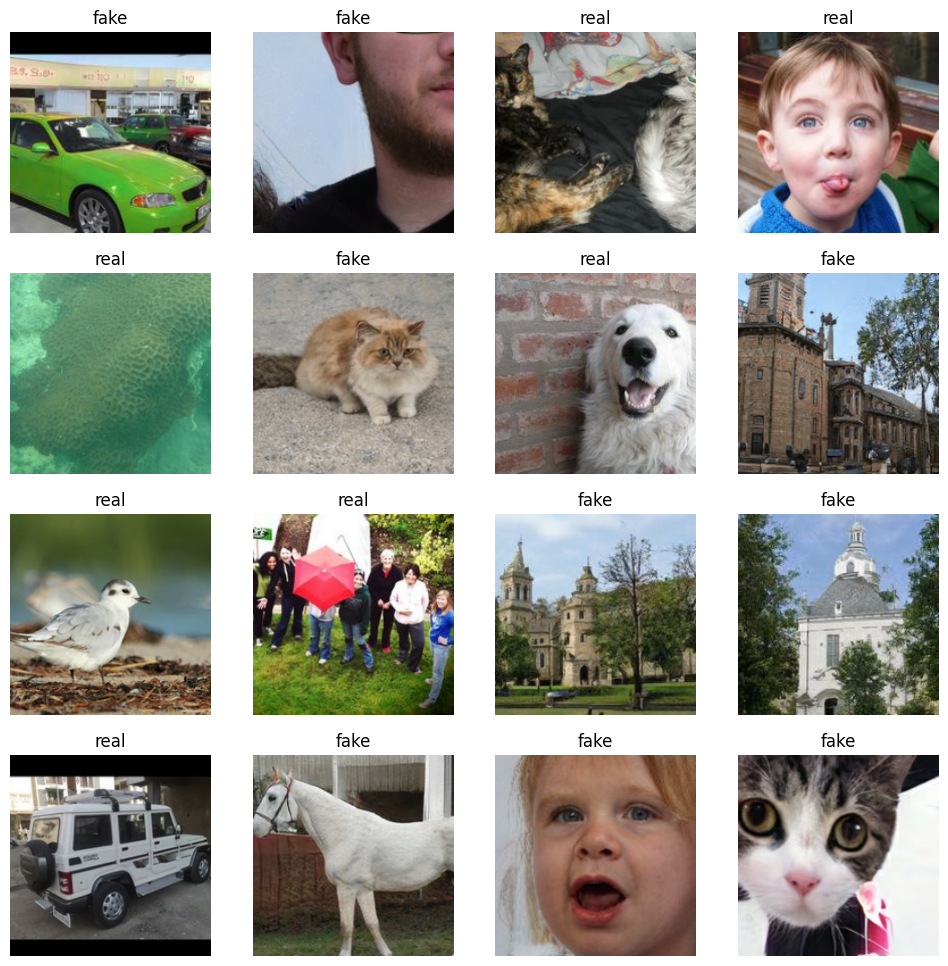

In [4]:
label_mapping = {
    0: "fake",
    1: "real"
}

# Função para formatar o rótulo
def format_label(label):
    return label_mapping[label.numpy()]

# Visualizar imagens com rótulos formatados
plt.figure(figsize=(12, 12))  # Aumentar o tamanho da figura
for i, (image, label) in enumerate(ds_train.take(16)):  # Ajustar o número de imagens para 16
    ax = plt.subplot(4, 4, i + 1)  # Ajustar a grade para 4x4
    plt.imshow(image.numpy().clip(0, 1))  # Exibir imagem normalizada
    plt.title("{}".format(format_label(label)))
    plt.axis("off")
plt.show()

### Data augmentation

Aplicar data augmentation para tentar tornar o modelo mais genérico durante o aprendizado

In [8]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

def safe_img_augmentation(image):
    try:
        return img_augmentation(image)
    except Exception as e:
        print(f"Erro na augmentação: {e}")
        return image  # Retorna a imagem original em caso de erro


#### Visualizar exemplo de augmentation

2024-12-07 00:52:05.755133: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47935176 exceeds 10% of free system memory.


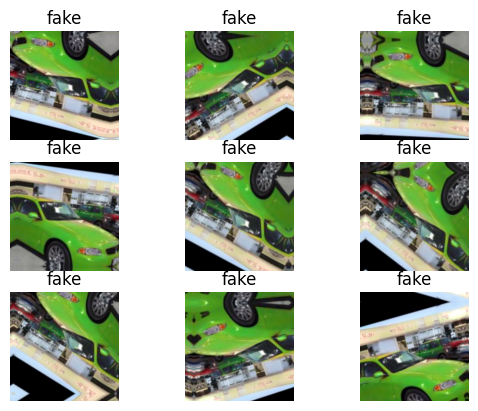

In [9]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].clip(0, 1))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

### Preparar entradas para o modelo

Aplicamos o image_augmentation para as imagens treino e teste, e é definido o formato one-hot-encoding para as categorias.
Além disso, é aplicado o batch e fetch nos dados a serem treinados

In [10]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = safe_img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Treinamento do zero do Modelo EfficientNetB0


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.applications import EfficientNetB0

# Configuração do modelo
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "precision", "recall", "f1_score"])

# Diretório para salvar checkpoints
CHECKPOINT_DIR = 'checkpoints/' + str(model.name) + '/'

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
# Arquivos de checkpoint do modelo 
checkpoint_files = [
    f for f in os.listdir(CHECKPOINT_DIR) if f.startswith("model_epoch_") and f.endswith(".keras")
]
# Carrega a partir do checkpoint caso exista algum modelo já salvo
if checkpoint_files:
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    last_checkpoint = os.path.join(CHECKPOINT_DIR, checkpoint_files[-1])
    print(f"Carregando modelo a partir do último checkpoint: {last_checkpoint}")
    model.load_weights(last_checkpoint)
    initial_epoch = int(checkpoint_files[-1].split('_')[-1].split('.')[0])
else:
    print("Nenhum checkpoint encontrado. Começando do zero.")
    initial_epoch = 0

# Call back para salvar os logs de desempenho do modelo ao final de cada epoca
class MetricsLogsEndEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        filepath_logs = os.path.join(CHECKPOINT_DIR, 'logs/')
        if not os.path.exists(filepath_logs):
            os.makedirs(filepath_logs)
        filename_logs = os.path.join(filepath_logs, 'logs_epoch_' + str(epoch)) 
        with open(filename_logs, 'w') as f:
            for key, value in logs.items():
                f.write('%s:%s\n' % (key, value))

# Callback para salvar o melhor modelo com base no menor val_loss
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callback para reduzir a taxa de aprendizado se o val_loss não melhorar
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
# Save model checkpoint at the end of the epoch
checkpoint_callback_epoch = tf.keras.callbacks.ModelCheckpoint(
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    filepath=os.path.join(CHECKPOINT_DIR, 'model_epoch_{epoch:02d}.keras')
)

# Treinamento do modelo
hist = model.fit(
    ds_train,
    initial_epoch=initial_epoch,
    validation_data=ds_test,
    epochs=40,  
    callbacks=[checkpoint_callback, reduce_lr_callback, MetricsLogsEndEpoch(), checkpoint_callback_epoch],
    verbose=1
)

# Salvar o modelo final
final_model_path = os.path.join(CHECKPOINT_DIR, 'final_model.keras')
model.save(final_model_path)
print(f"Modelo final salvo em: {final_model_path}")

Carregando modelo a partir do último checkpoint: checkpoints/efficientnetb0/model_epoch_17.keras
Epoch 18/40


I0000 00:00:1732951859.068878   33731 service.cc:146] XLA service 0x7f6aa8003800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732951859.068924   33731 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-30 04:30:59.834082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 04:31:02.662083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1732951901.982501   33731 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6002 - f1_score: 0.4967 - loss: 0.8307 - precision: 0.6002 - recall: 0.6002

2024-11-30 04:31:51.380281: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2083', 20 bytes spill stores, 20 bytes spill loads

2024-11-30 04:31:51.451908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2083', 248 bytes spill stores, 248 bytes spill loads




Epoch 18: val_loss improved from inf to 1.54481, saving model to checkpoints/efficientnetb0/best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 83s 227ms/step - accuracy: 0.6003 - f1_score: 0.4971 - loss: 0.8306 - precision: 0.6003 - recall: 0.6003 - val_accuracy: 0.5958 - val_f1_score: 0.5583 - val_loss: 1.5448 - val_precision: 0.5958 - val_recall: 0.5958 - learning_rate: 0.0010
Epoch 19/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6186 - f1_score: 0.5400 - loss: 0.7606 - precision: 0.6186 - recall: 0.6186
Epoch 19: val_loss did not improve from 1.54481
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.6184 - f1_score: 0.5401 - loss: 0.7604 - precision: 0.6184 - recall: 0.6184 - val_accuracy: 0.5104 - val_f1_score: 0.5065 - val_loss: 2.5376 - val_precision: 0.5104 - val_recall: 0.5104 - learning_rate: 0.0010
Epoch 20/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6458 - f1_score: 0.5823 - loss: 0.6937 - precision: 0.6458 - recall: 0.6458
Epoch 20: val_loss improved

## Resultados

### Matriz de confusão conjunto de validação

Processing batches: 100%|██████████| 7801/7801 [14:17<00:00,  9.10it/s]


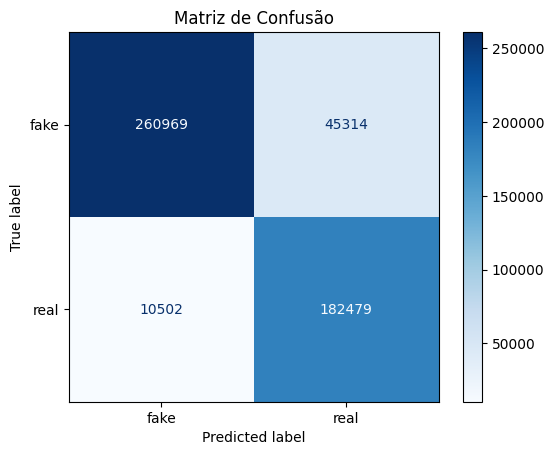

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Carregar o melhor modelo salvo
model = tf.keras.models.load_model('checkpoints/efficientnetb0/best_model.keras')

y_true = []
y_pred = []
for images, labels in tqdm(ds_test, desc="Processing batches"):
    predictions = model.predict(images, verbose=0)  
    y_true.extend(np.argmax(labels.numpy(), axis=1))  
    y_pred.extend(np.argmax(predictions, axis=1))  

# Criar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["fake", "real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()


### Métricas de avaliação em cada época

Processamento dos arquivos logs gerados no treinamento

In [39]:
import pandas as pd
import numpy as np
import re

base_dir = "checkpoints/efficientnetb0/logs/"
# Lista de arquivos de logs
log_files = [base_dir + f'logs_epoch_{i}' for i in range(40)]  # Para arquivos de log de 0 a 39
# Inicializando uma lista para armazenar os dados
logs_data = []

def extract_metrics_from_log(log_file):
    with open(log_file, 'r') as file:
        lines = file.readlines()
    metrics = {}
    for line in lines:
        if 'val_accuracy' in line:
            metrics['val_accuracy'] = float(line.split(":")[1].strip())
        elif 'val_f1_score' in line:
            f1_values = re.search(r'\[(.*?)\]', line).group(1).strip()
            f1_values = f1_values.split()
            metrics['val_f1_score_0'] = float(f1_values[0])
            metrics['val_f1_score_1'] = float(f1_values[1])
        elif 'val_loss' in line:
            metrics['val_loss'] = float(line.split(":")[1].strip())
        elif 'val_precision' in line:
            metrics['val_precision'] = float(line.split(":")[1].strip())
        elif 'val_recall' in line:
            metrics['val_recall'] = float(line.split(":")[1].strip())
        elif 'accuracy' in line:
            metrics['accuracy'] = float(line.split(":")[1].strip())
        elif 'f1_score' in line:
            f1_values = re.search(r'\[(.*?)\]', line).group(1).strip()
            f1_values = f1_values.split()
            metrics['f1_score_0'] = float(f1_values[0])
            metrics['f1_score_1'] = float(f1_values[1])
        elif 'loss' in line:
            metrics['loss'] = float(line.split(":")[1].strip())
        elif 'precision' in line:
            metrics['precision'] = float(line.split(":")[1].strip())
        elif 'recall' in line:
            metrics['recall'] = float(line.split(":")[1].strip())
        
        # elif 'learning_rate' in line:
            # metrics['learning_rate'] = float(line.split(":")[1].strip())
    
    return metrics

# Iterando sobre os arquivos de log e extraindo as métricas
for log_file in log_files:
    metrics = extract_metrics_from_log(log_file)
    logs_data.append(metrics)

Exibição dos gráficos a partir dos logs processados

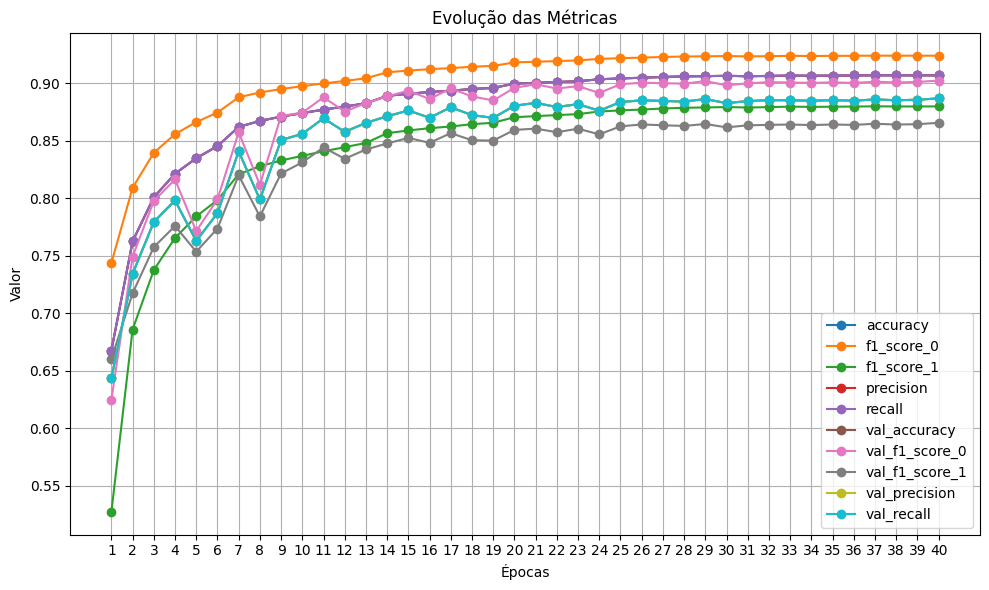

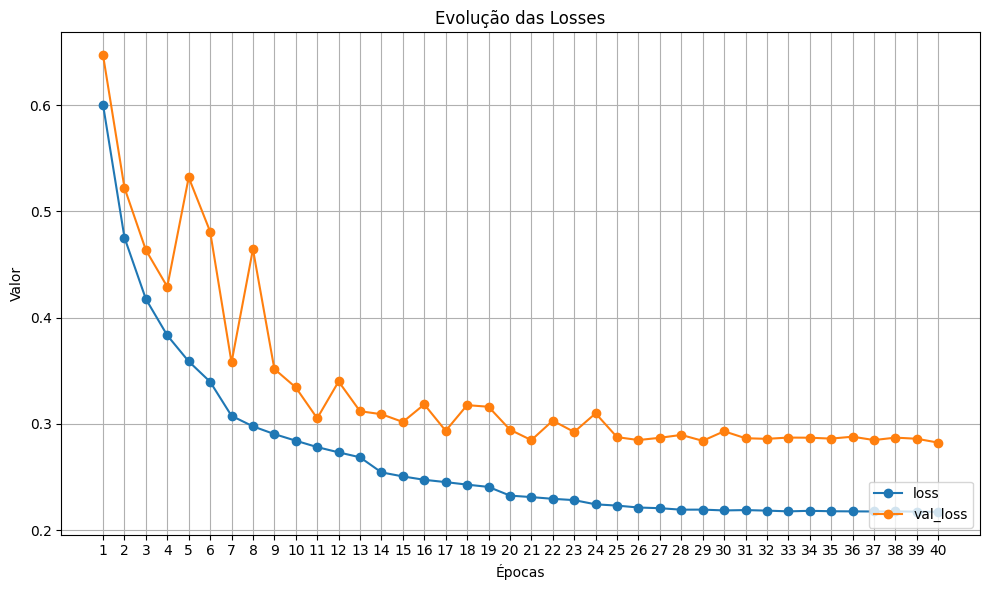

In [40]:
df = pd.DataFrame(logs_data)

# Identificar as métricas
metrics = ['accuracy', 'f1_score_0', 'f1_score_1', 'precision', 'recall', 'val_accuracy', 'val_f1_score_0', 'val_f1_score_1', 'val_precision', 'val_recall']
loss_metric = ['loss', 'val_loss']

# Gráfico de linhas para métricas
def plot_line_metrics(df, metrics, title):
    df[metrics].plot(kind='line', marker='o', figsize=(10, 6))
    plt.title(title)
    plt.ylabel("Valor")
    plt.xlabel("Épocas")
    plt.xticks(ticks=range(len(df)), labels=[f"{i+1}" for i in range(len(df))])
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Gerar gráficos de linhas para métricas e perda
plot_line_metrics(df, metrics, "Evolução das Métricas")
plot_line_metrics(df, loss_metric, "Evolução das Losses")